<center>
<h style="line-height: 0.5;">

# Applying Machine Learning to Gravitational Lens Modeling
#### <ins>Research Advisor</ins>: Professor Charles Keeton
#### <ins>Student</ins>: Satyajit Gade

</h>
</center>

In [12]:
# imports all the modules needed

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import emcee
import corner
import arviz
import pygravlens as gl
from astropy.cosmology import Planck18 as cosmo

from matplotlib.patches import Arc
from pathlib import Path

### Generating Corner/Scatter Plots

In [13]:
# Dr. Keeton's code:

def visualize_data(dataarray,colorindex,labels,title):
    f,ax = plt.subplots(4,4,figsize=(16,16))
    f.suptitle(title,fontsize=16)
    for i1 in range(4):
        for i2 in range(4):
            if i2<=i1:
                ax[i1][i2].scatter(dataarray[:,i2],dataarray[:,i1+1],c=dataarray[:,colorindex],marker='o')
                ax[i1][i2].set_xlabel(labels[i2], fontsize=14)
                ax[i1][i2].set_ylabel(labels[i1+1], fontsize=14)
            else:
                ax[i1][i2].axis('off')
    ax[0][1].text(0.5,0.5,'color: '+labels[colorindex],ha='center',va='center', fontsize=14)
    f.tight_layout()
    plt.show()

In [14]:
# Amarel Output Folder
data_path = Path("CombinedArrays")

### Shear Only

In [15]:
vals_shear = np.load(data_path / 'valShear.npy', allow_pickle = True)

In [17]:
# printing out specificed dictionary values for img, magnification, and time-delay arrays
'''
for i in range(len(vals_shear)):
    print('Here is the image array: \n', vals_shear[i]["img"], '\n')
    print('Here is the magnification array: \n', vals_shear[i]["mu"], '\n')
    print('Here is the time delay array: \n', vals_shear[i]["time"], '\n')
    ---
    print('Here is the ellip_c array: \n', values[i]["ellipc"], '\n')
    print('Here is the ellip_s array: \n', values[i]["ellips"], '\n')
    print('Here is the gamma_c array: \n', values[i]["gammc"], '\n')
    print('Here is the gamma_s array: \n', values[i]["gamms"], '\n')
    print()
    ---
    print('----------------------------Next Mock Lens----------------------------')
'''    
# note that the values dictionary contains i elements where i represents the number of mock lenses

# now we define a separate dictionary containing keys as "single," "double," or "quad" 
# with values as the index of the mock lens for single, double, and quad lenses respectively

single = [];
double = [];
quad = [];

weirdCase = []
for i in range(len(vals_shear)):
    size = len(vals_shear[i]["img"]);
    neither = {}
    if size == 4:
        quad.append(i)
    elif size == 2:
        double.append(i)
    elif size == 1:
        single.append(i)
    else:
        neither = dict(index = i, size = size)
    weirdCase.append(neither)

typeLens = dict(single = single, double = double, quad = quad)

print("The index array for a single image producing mock lens is: ", typeLens["single"],'\n')
print("The index array for a double image producing mock lens is: ", typeLens["double"],'\n')
print("The index array for a quad image producing mock lens is: ", typeLens["quad"],'\n')

for j in weirdCase:
    sz = len(j)
    if sz != 0:
        print("The index for neither single, double, or quad is: ", j["index"],'\n')
        print("And the images produced by this lens are: ", j["size"],'\n')
        print('----------------------------Next Non Single, Double, or Quad Mock Lens----------------------------')

The index array for a single image producing mock lens is:  [367, 402, 929, 1246, 1268, 1278, 1645, 1969, 2146, 2652, 2971, 2983, 3052, 4001, 4185, 4368, 4526, 4639, 4941, 5085, 6314, 6366, 6721, 6987, 7130, 7587, 8266, 8644, 8880, 9058, 9561, 9678, 9693, 10531, 10699, 10840, 11597, 11681, 12014, 12223, 12330, 12635, 12877, 13330, 13463, 13478, 13647, 15485, 15762, 15930, 15973, 16144, 16263, 16271, 16330, 16993, 17318, 17489, 18836, 19177, 19208, 19780, 19793, 20458, 20807, 20877, 21415, 21916, 22114, 22185, 22407, 22575, 22768, 23040, 23525, 23628, 23771, 23929, 23937, 24355, 24608, 25233, 25429, 25854, 26228, 26310, 26512, 26611, 26941, 27175, 27492, 28231, 28394, 28690, 29174, 29431, 30121, 30650, 30814, 30984, 30997, 31049, 31179, 31378, 31733, 31926, 31974, 32008, 32184, 32220, 33340, 33720, 34007, 34281, 34543, 34622, 34928, 34987, 35227, 35352, 35402, 35979, 36057, 36586, 36688, 37646, 37825, 37910, 37935, 38102, 38770, 39004, 39342, 39519, 39609, 39999, 40233, 40572, 40903, 40

#### Visualizing Shear-Only data

Text(0.5, 1.0, 'Graph of Image Positions (SIS+shear)')

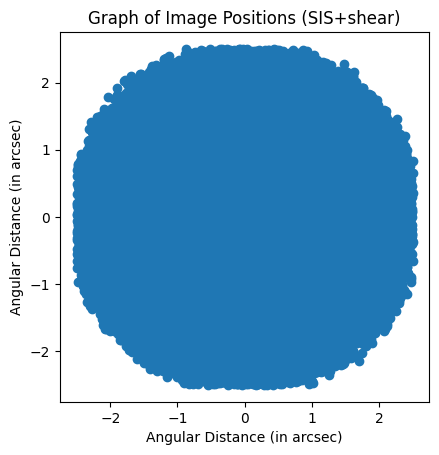

In [18]:
imX_shear = [];
imY_shear = [];


for i in typeLens["single"]:
    elem = vals_shear[i]["img"]
    imX_shear.append(elem[0][0])
    imY_shear.append(elem[0][1])

for i in typeLens["double"]:
    elem = vals_shear[i]["img"]
    imX_shear.append(elem[0][0])
    imX_shear.append(elem[1][0])
    imY_shear.append(elem[0][1])
    imY_shear.append(elem[1][1])
    
for i in typeLens["quad"]:
    elem = vals_shear[i]["img"]
    imX_shear.append(elem[0][0])
    imX_shear.append(elem[1][0])
    imX_shear.append(elem[2][0])
    imX_shear.append(elem[3][0])
    
    imY_shear.append(elem[0][1])
    imY_shear.append(elem[1][1])
    imY_shear.append(elem[2][1])
    imY_shear.append(elem[3][1])

newX_shear = np.array(imX_shear)
newY_shear = np.array(imY_shear)

plt.scatter(newX_shear, newY_shear)

betaOne_shear = [vals_shear[i]["betaOne"] for i in range(len(vals_shear))]
betaTwo_shear = [vals_shear[i]["betaTwo"] for i in range(len(vals_shear))]

plt.gca().set_aspect('equal')

plt.xlabel('Angular Distance (in arcsec)')
plt.ylabel('Angular Distance (in arcsec)')
plt.title('Graph of Image Positions (SIS+shear)')


Text(0.5, 1.0, 'Graph of Source Positions (SIS+shear)')

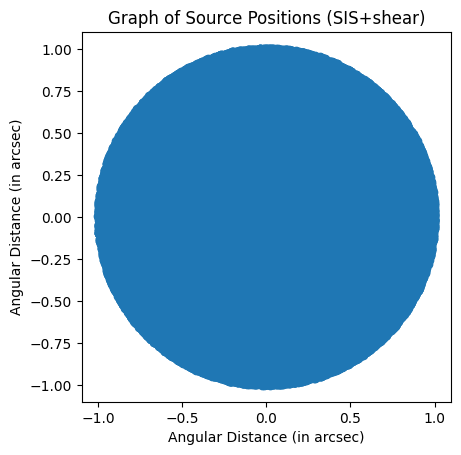

In [19]:
plt.scatter(betaOne_shear,betaTwo_shear)
plt.gca().set_aspect('equal')

plt.xlabel('Angular Distance (in arcsec)')
plt.ylabel('Angular Distance (in arcsec)')
plt.title('Graph of Source Positions (SIS+shear)')

Text(0.5, 1.0, 'Graph of Source and Image Positions Overlayed (SIS+shear)')

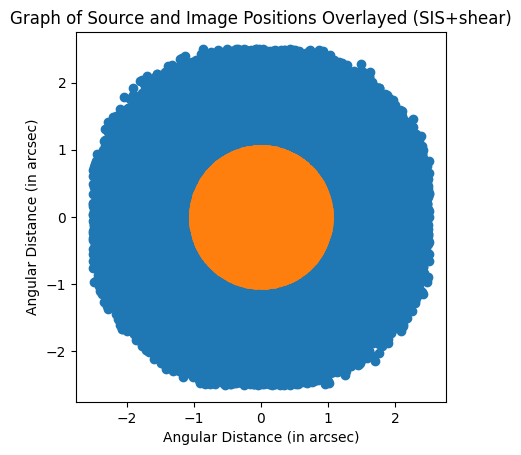

In [20]:
plt.scatter(newX_shear, newY_shear)
plt.scatter(betaOne_shear,betaTwo_shear)
plt.gca().set_aspect('equal')

plt.xlabel('Angular Distance (in arcsec)')
plt.ylabel('Angular Distance (in arcsec)')
plt.title('Graph of Source and Image Positions Overlayed (SIS+shear)')

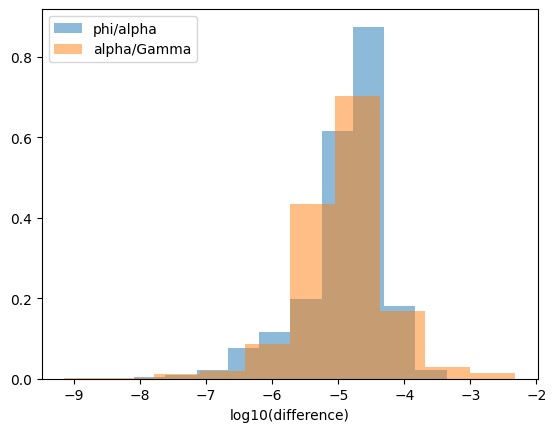

c:\Users\satya\Documents\GravLensing\pygravlens.py:1571: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


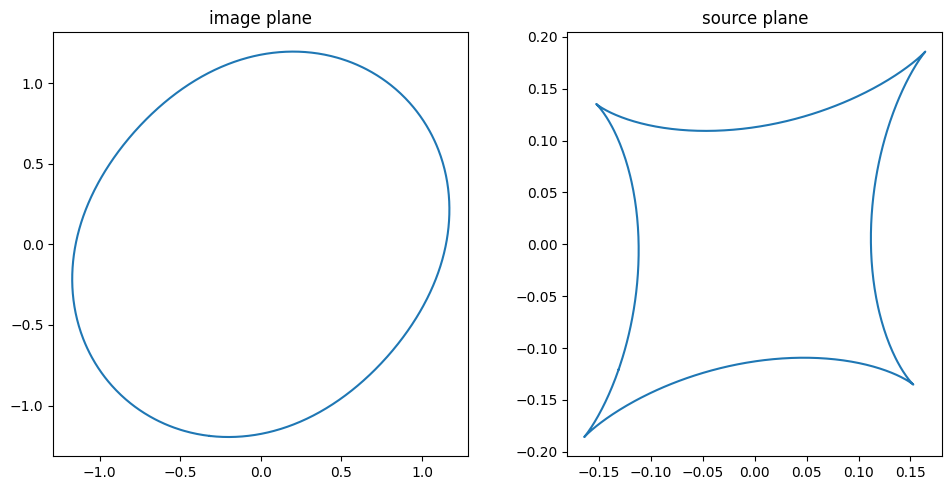

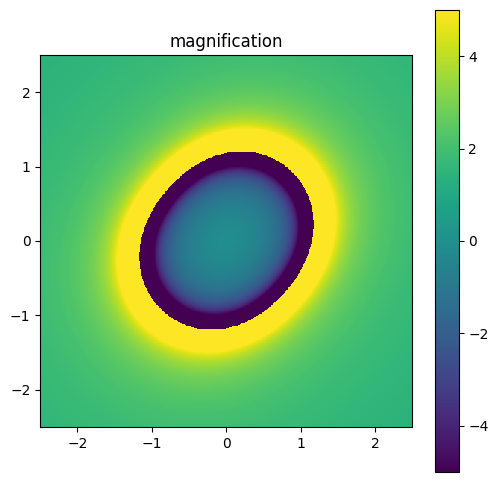

c:\Users\satya\Documents\GravLensing\pygravlens.py:1641: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


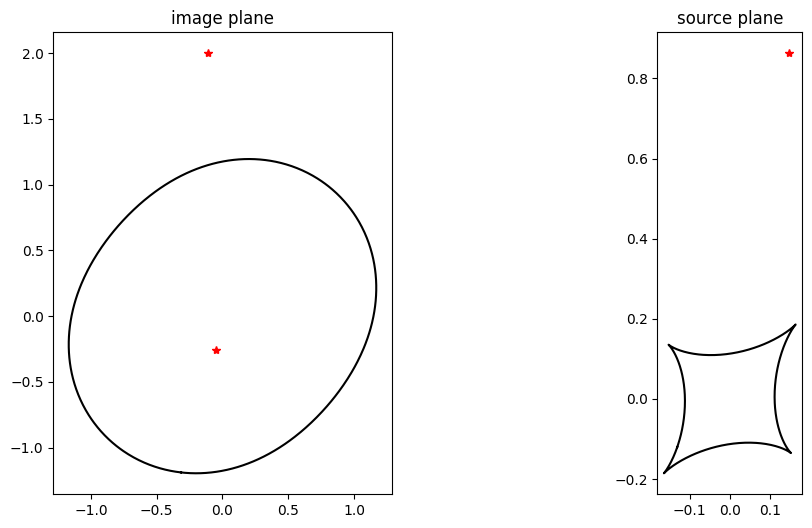

In [21]:
# Arbitrary point chosen from above list of points to graph.

betaOne = betaOne_shear[26]
betaTwo = betaTwo_shear[26] # choose
betaArray= [betaOne, betaTwo] 

eins = [vals_shear[i]["einrad"] for i in range(len(vals_shear))]

# array of randomized shear vals between 0 and 0.1, same size as eins array
gc = [vals_shear[i]["gammc"] for i in range(len(vals_shear))]
gs = [vals_shear[i]["gamms"] for i in range(len(vals_shear))]
 
ellip = 0.0

xtmp_elpow = np.random.uniform(low=-2,high=2,size=(1000,2))

plane_elpow = gl.lensplane('ellpow',[0.0,0.0,1.0,eins[26],ellip,ellip],gammac=gc[26],gammas=gs[26])
plane_elpow.check(xtmp_elpow)

model_elpow = gl.lensmodel([plane_elpow])
model_elpow.tile()
model_elpow.plotcrit()
model_elpow.plotmag()

imgarr,muarr,tarr = model_elpow.findimg(betaArray)
model_elpow.plot(src=betaArray)



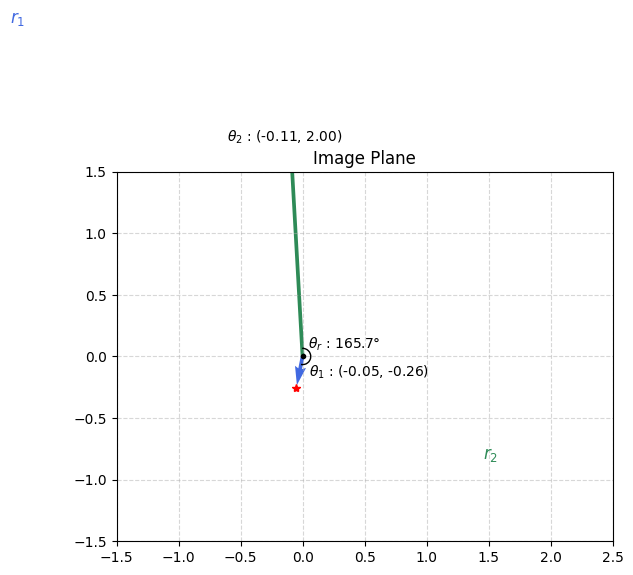

In [22]:
fig2,ax2 = plt.subplots()
x_lim = ax2.set_xlim(-1.5,2.5)
y_lim = ax2.set_ylim(-1.5,1.5)

r_im1 = np.array(imgarr[0])
r_im2 = np.array(imgarr[1])
v_orig = np.array(imgarr)

# reducing the size of vectors for clarity of eyes
v_orig[0] = 0.98*v_orig[0]
v_orig[1] = 0.9*v_orig[1]

V = v_orig.T
origin = np.array([[0,0],[0,0]]).T

cos_theta = np.dot(r_im1, r_im2) / (np.linalg.norm(r_im1) * np.linalg.norm(r_im2))
theta_rad = np.arccos(np.clip(cos_theta, -1, 1))  # Clip to avoid numerical errors
theta_deg = np.degrees(theta_rad)  # Convert to degrees

ax2.plot(0, 0, marker='.',color='black')
ax2.plot(r_im2[0], r_im2[1], marker='*',color='red', label=f'Image 1: ({r_im2[0]:.2f}, {r_im2[1]:.2f})')
ax2.plot(r_im1[0], r_im1[1], marker='*',color='red', label=f'Image 2: ({r_im1[0]:.2f}, {r_im1[1]:.2f})')


# Get vector angles for proper arc placement
angle1 = np.degrees(np.arctan2(r_im1[1], r_im1[0]))
angle2 = np.degrees(np.arctan2(r_im2[1], r_im2[0]))

# Add angle arc (radius = min vector length * 0.5)
radius = 0.25 * min(np.linalg.norm(r_im1), np.linalg.norm(r_im2))  # Reduced radius
arc = Arc((0, 0), 2*radius, 2*radius, angle=0,
          theta1=min(angle1, angle2), theta2=max(angle1, angle2),
          color='black', lw=1, zorder=3)
ax2.add_patch(arc)


# Add coordinate labels 
plt.text(r_im1[0]-0.5, r_im1[1] - 0.25, r'$\theta_2$ : ' + f'({r_im1[0]:.2f}, {r_im1[1]:.2f})', fontsize=10)
plt.text(r_im2[0] + 0.1, r_im2[1]+0.1, r'$\theta_1$ : ' + f'({r_im2[0]:.2f}, {r_im2[1]:.2f})', fontsize=10)

mid_angle = (angle1 + angle2)/2
label_x = 0.5 * radius * np.cos(np.radians(mid_angle))
label_y = 0.5 * radius * np.sin(np.radians(mid_angle))
ax2.text(label_x + 0.3, label_y+0.1, r'$\theta_r$ : ' + f'{theta_deg:.1f}°', 
        color='black', fontsize=10, ha='center', va='center')
# vector plot
ax2.quiver(origin[0], origin[1], V[0], V[1], color=['seagreen', 'royalblue'], angles='xy', scale_units='xy', scale=1)

ax2.text(v_orig[0][0] - 2.25, v_orig[0][1] + 0.75, r'$r_1$',size=12,color='royalblue')
ax2.text(v_orig[1][0] + 1.5, v_orig[1][1] - 0.60, r'$r_2$',size=12,color='seagreen')

#labels
ax2.grid(linestyle='--', alpha=0.5)
#ax2.legend(loc='best')  # Show legend with coordinates
plt.title("Image Plane")
# model_elpow.plot(src=betaArray)
plt.show()


In [23]:
print("src: ", betaArray, "\n")
print("image: ", imgarr, "\n")
print("mag: ", muarr, "\n")
print("time del: ", tarr, "\n")

src:  [np.float64(0.146885463933569), np.float64(0.8629673603783691)] 

image:  [[-0.11162426  1.9993824 ]
 [-0.05083285 -0.25853373]] 

mag:  [ 2.40890924 -0.2788816 ] 

time del:  [0.         1.97067247] 



In [25]:
def unit_vector(vector):
    # Returns the unit vector of the vector.  
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    # Returns the angle in radians between vectors 'v1' and 'v2'
    
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

#### Corner Plots for SIS+shear

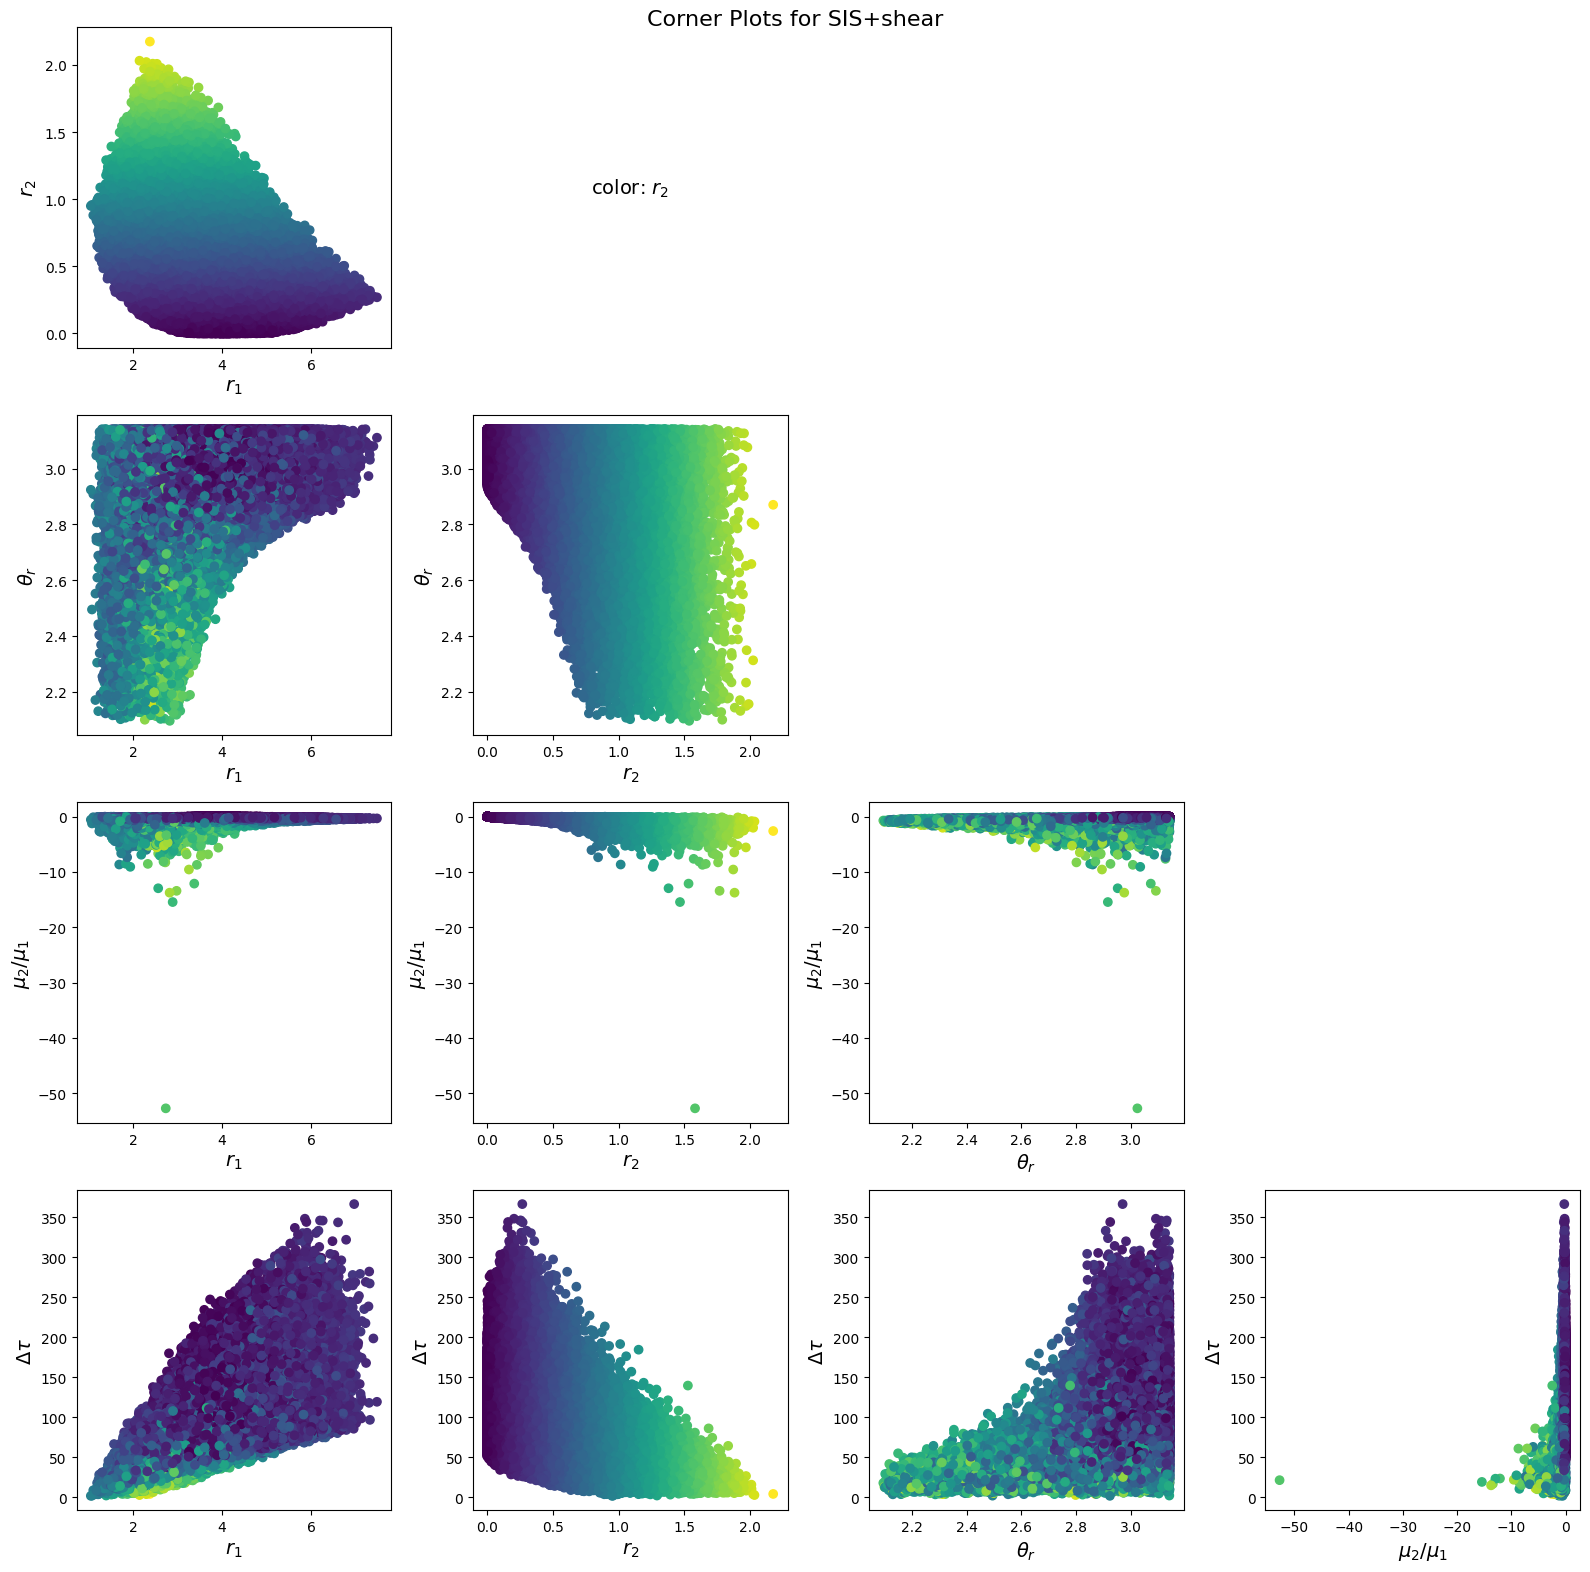

In [26]:
r_1 = [];
r_2 = [];

for i in typeLens["double"]:
    elem = vals_shear[i]["img"]
    r_1.append(elem[0])
    r_2.append(elem[1])

theta_r = [];
for i in range(len(r_1)):
    theta_r.append(angle_between(r_1[i], r_2[i]))

R_1 = np.array([r_1[i][0]**2 + r_1[i][1]**2 for i in range(len(r_1))])
R_2 = np.array([r_2[i][0]**2 + r_2[i][1]**2 for i in range(len(r_2))])

mu_1 = np.array([vals_shear[i]["mu"][0] for i in typeLens["double"]])
mu_2 = np.array([vals_shear[i]["mu"][1] for i in typeLens["double"]])

ratio_mag = mu_2 / mu_1

timeDel_1 = np.array([vals_shear[i]["time"][0].value for i in typeLens["double"]]) # this is always zero, so only second is interesting
timeDel_2 = np.array([vals_shear[i]["time"][1].value for i in typeLens["double"]]) # second on is more interesting so would be focus.

tau = timeDel_2 - timeDel_1

### Time delay distance

z_l = np.array([vals_shear[i]["zLens"] for i in typeLens["double"]])
z_s = np.array([vals_shear[i]["zSrc"] for i in typeLens["double"]])

Dlens = [];
Dsrc = [];

for i in range(len(z_l)):
    Dlens.append(cosmo.comoving_distance(z_l[i]).value);
    Dsrc.append(cosmo.comoving_distance(z_s[i]).value);
    
D_l = np.array(Dlens)
D_s = np.array(Dsrc)

D_t = (D_l * D_s ) / (D_s - D_l) 

data = np.column_stack((R_1, R_2, theta_r, ratio_mag, tau)) # takes multiple arrays and stacks them on top of each other.
#r_1 refers to radius of image 1 and r_2 refers to radius of image 2.
visualize_data(data, 1, ['$r_1$', '$r_2$', r'$\theta_r$',r'$\mu_2 / \mu_1$',r'$\Delta\tau$'], 'Corner Plots for SIS+shear') 


### Ellipticity Only

In [27]:
vals_ellip = np.load(data_path / 'valEllip.npy', allow_pickle = True)

In [28]:
# printing out specificed dictionary values for img, magnification, and time-delay arrays
'''
for i in range(len(vals_ellip)):
    print('Here is the image array: \n', vals_ellip[i]["img"], '\n')
    print('Here is the magnification array: \n', vals_ellip[i]["mu"], '\n')
    print('Here is the time delay array: \n', vals_ellip[i]["time"], '\n')
    --
    print('Here is the ellip_c array: \n', values[i]["ellipc"], '\n')
    print('Here is the ellip_s array: \n', values[i]["ellips"], '\n')
    print('Here is the gamma_c array: \n', values[i]["gammc"], '\n')
    print('Here is the gamma_s array: \n', values[i]["gamms"], '\n')
    print()
    ---
    print('----------------------------Next Mock Lens----------------------------')
'''
    
# note that the values dictionary contains i elements where i represents the number of mock lenses

# now we define a separate dictionary containing keys as "single," "double," or "quad" 
# with values as the index of the mock lens for single, double, and quad lenses respectively

single = [];
double = [];
quad = [];

weirdCase = []
for i in range(len(vals_ellip)):
    size = len(vals_ellip[i]["img"]);
    neither = {}
    if size == 4:
        quad.append(i)
    elif size == 2:
        double.append(i)
    elif size == 1:
        single.append(i)
    else:
        neither = dict(index = i, size = size)
    weirdCase.append(neither)

typeLens_ellip = dict(single = single, double = double, quad = quad)

print("The index array for a single image producing mock lens is: ", typeLens_ellip["single"],'\n')
print("The index array for a double image producing mock lens is: ", typeLens_ellip["double"],'\n')
print("The index array for a quad image producing mock lens is: ", typeLens_ellip["quad"],'\n')

for j in weirdCase:
    sz = len(j)
    if sz != 0:
        print("The index for neither single, double, or quad is: ", j["index"],'\n')
        print("And the images produced by this lens are: ", j["size"],'\n')
        print('----------------------------Next Non Single, Double, or Quad Mock Lens----------------------------')

The index array for a single image producing mock lens is:  [21, 79, 83, 114, 135, 141, 233, 246, 327, 366, 377, 410, 445, 449, 471, 473, 497, 510, 523, 534, 538, 543, 545, 555, 556, 558, 568, 574, 591, 605, 608, 609, 615, 617, 635, 639, 650, 655, 675, 676, 677, 681, 725, 729, 730, 748, 775, 801, 811, 860, 929, 974, 980, 992, 1017, 1021, 1033, 1085, 1089, 1145, 1153, 1157, 1162, 1182, 1186, 1190, 1194, 1230, 1246, 1249, 1262, 1267, 1268, 1269, 1278, 1283, 1299, 1313, 1321, 1340, 1345, 1418, 1460, 1472, 1479, 1493, 1496, 1506, 1508, 1546, 1547, 1549, 1550, 1557, 1584, 1597, 1615, 1629, 1633, 1638, 1667, 1675, 1683, 1698, 1709, 1734, 1751, 1763, 1764, 1786, 1806, 1810, 1825, 1833, 1938, 1967, 1977, 1983, 1985, 2007, 2020, 2032, 2065, 2074, 2090, 2105, 2117, 2182, 2185, 2212, 2223, 2244, 2277, 2309, 2316, 2342, 2343, 2376, 2386, 2397, 2416, 2433, 2446, 2531, 2546, 2563, 2575, 2578, 2589, 2619, 2639, 2652, 2656, 2667, 2710, 2713, 2740, 2815, 2854, 2855, 2865, 2873, 2879, 2913, 2939, 2941, 

#### Visualizing Ellipticity-Only Data

Text(0.5, 1.0, 'Graph of Image Positions (SIE)')

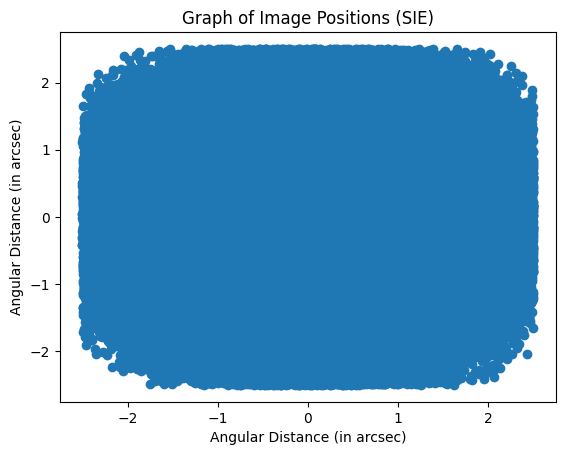

In [29]:
imX_ellip = [];
imY_ellip = [];

for i in typeLens_ellip["single"]:
    elem = vals_ellip[i]["img"]
    imX_ellip.append(elem[0][0])
    imY_ellip.append(elem[0][1])

for i in typeLens_ellip["double"]:
    elem = vals_ellip[i]["img"]
    imX_ellip.append(elem[0][0])
    imX_ellip.append(elem[1][0])
    imY_ellip.append(elem[0][1])
    imY_ellip.append(elem[1][1])
    
for i in typeLens_ellip["quad"]:
    elem = vals_ellip[i]["img"]
    imX_ellip.append(elem[0][0])
    imX_ellip.append(elem[1][0])
    imX_ellip.append(elem[2][0])
    imX_ellip.append(elem[3][0])
    
    imY_ellip.append(elem[0][1])
    imY_ellip.append(elem[1][1])
    imY_ellip.append(elem[2][1])
    imY_ellip.append(elem[3][1])
    

newX_ellip = np.array(imX_ellip)
newY_ellip = np.array(imY_ellip)

plt.scatter(newX_ellip, newY_ellip)

plt.xlabel('Angular Distance (in arcsec)')
plt.ylabel('Angular Distance (in arcsec)')
plt.title('Graph of Image Positions (SIE)')


Text(0.5, 1.0, 'Graph of Source Positions (SIE)')

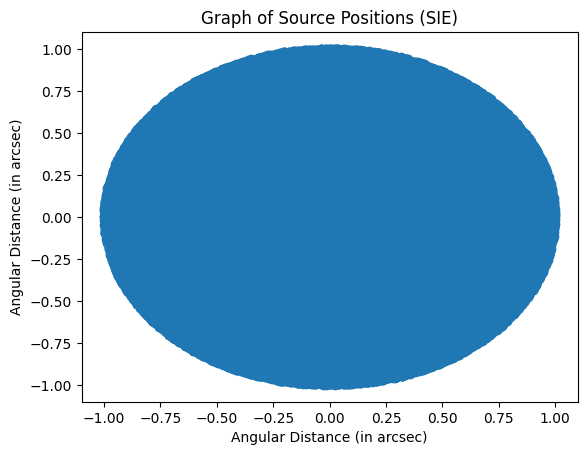

In [30]:
betaOne_ellip = [vals_ellip[i]["betaOne"] for i in range(len(vals_ellip))]
betaTwo_ellip = [vals_ellip[i]["betaTwo"] for i in range(len(vals_ellip))]
plt.scatter(betaOne_ellip,betaTwo_ellip)

plt.xlabel('Angular Distance (in arcsec)')
plt.ylabel('Angular Distance (in arcsec)')
plt.title('Graph of Source Positions (SIE)')

#### Corner Plots for SIE

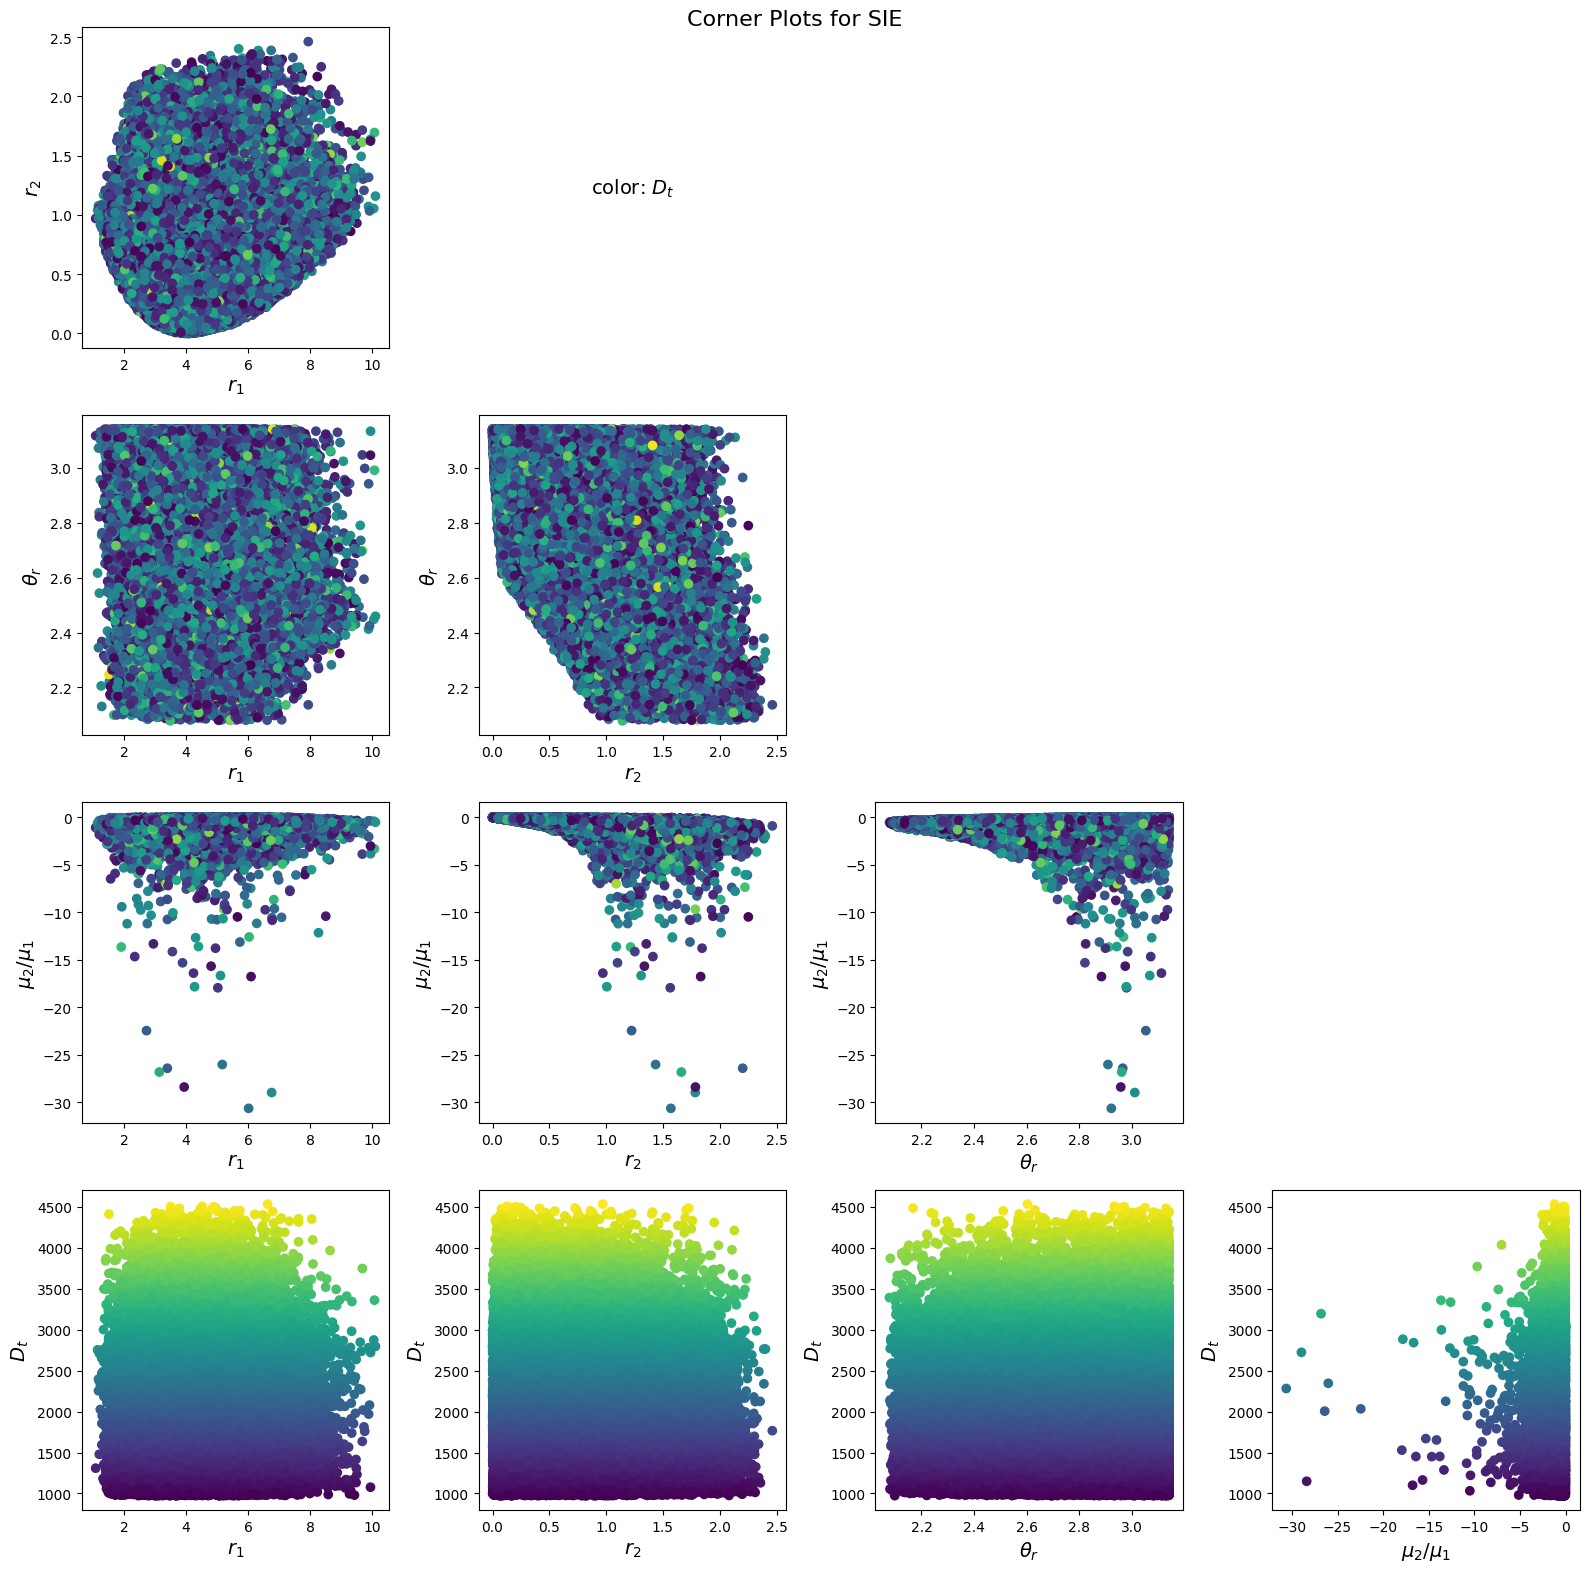

In [31]:
r_1 = [];
r_2 = [];

for i in typeLens_ellip["double"]:
    elem = vals_ellip[i]["img"]
    r_1.append(elem[0])
    r_2.append(elem[1])

theta_r = [];
for i in range(len(r_1)):
    theta_r.append(angle_between(r_1[i], r_2[i]))

R_1 = np.array([r_1[i][0]**2 + r_1[i][1]**2 for i in range(len(r_1))])
R_2 = np.array([r_2[i][0]**2 + r_2[i][1]**2 for i in range(len(r_2))])

mu_1 = np.array([vals_ellip[i]["mu"][0] for i in typeLens_ellip["double"]])
mu_2 = np.array([vals_ellip[i]["mu"][1] for i in typeLens_ellip["double"]])

ratio_mag = mu_2 / mu_1

timeDel_1 = np.array([vals_ellip[i]["time"][0].value for i in typeLens_ellip["double"]]) # this is always zero, so only second is interesting
timeDel_2 = np.array([vals_ellip[i]["time"][1].value for i in typeLens_ellip["double"]]) # second on is more interesting so would be focus.

tau = timeDel_2 - timeDel_1

### Time delay distance

z_l = np.array([vals_ellip[i]["zLens"] for i in typeLens_ellip["double"]])
z_s = np.array([vals_ellip[i]["zSrc"] for i in typeLens_ellip["double"]])

Dlens = [];
Dsrc = [];

for i in range(len(z_l)):
    Dlens.append(cosmo.comoving_distance(z_l[i]).value);
    Dsrc.append(cosmo.comoving_distance(z_s[i]).value);
    
D_l = np.array(Dlens)
D_s = np.array(Dsrc)

D_t = (D_l * D_s ) / (D_s - D_l) 

data = np.column_stack((R_1, R_2, theta_r, ratio_mag, D_t)) # takes multiple arrays and stacks them on top of each other.
#r_1 refers to radius of image 1 and r_2 refers to radius of image 2.
visualize_data(data, 4,['$r_1$', '$r_2$', r'$\theta_r$',r'$\mu_2 / \mu_1$', r'$D_t$'], 'Corner Plots for SIE')

### Ellipticity & Shear

In [32]:
vals_both = np.load(data_path / 'valBoth.npy', allow_pickle = True)

In [33]:
# printing out specificed dictionary values for img, magnification, and time-delay arrays
'''
for i in range(len(vals_both)):
    print('Here is the image array: \n', vals_both[i]["img"], '\n')
    print('Here is the magnification array: \n', vals_both[i]["mu"], '\n')
    print('Here is the time delay array: \n', vals_both[i]["time"], '\n')
    ---
    print('Here is the ellip_c array: \n', values[i]["ellipc"], '\n')
    print('Here is the ellip_s array: \n', values[i]["ellips"], '\n')
    print('Here is the gamma_c array: \n', values[i]["gammc"], '\n')
    print('Here is the gamma_s array: \n', values[i]["gamms"], '\n')
    print()
    ---
    print('----------------------------Next Mock Lens----------------------------')
'''    
# note that the values dictionary contains i elements where i represents the number of mock lenses

# now we define a separate dictionary containing keys as "single," "double," or "quad" 
# with values as the index of the mock lens for single, double, and quad lenses respectively

single = [];
double = [];
quad = [];

weirdCase = []
for i in range(len(vals_both)):
    size = len(vals_both[i]["img"]);
    neither = {}
    if size == 4:
        quad.append(i)
    elif size == 2:
        double.append(i)
    elif size == 1:
        single.append(i)
    else:
        neither = dict(index = i, size = size)
    weirdCase.append(neither)

typeLens_both = dict(single = single, double = double, quad = quad)

print("The index array for a single image producing mock lens is: ", typeLens_both["single"],'\n')
print("The index array for a double image producing mock lens is: ", typeLens_both["double"],'\n')
print("The index array for a quad image producing mock lens is: ", typeLens_both["quad"],'\n')

for j in weirdCase:
    sz = len(j)
    if sz != 0:
        print("The index for neither single, double, or quad is: ", j["index"],'\n')
        print("And the images produced by this lens are: ", j["size"],'\n')
        print('----------------------------Next Non Single, Double, or Quad Mock Lens----------------------------')

The index array for a single image producing mock lens is:  [21, 37, 79, 83, 88, 95, 114, 135, 136, 141, 201, 233, 246, 327, 334, 366, 367, 377, 392, 402, 410, 425, 445, 461, 471, 497, 523, 534, 542, 543, 545, 555, 556, 558, 568, 574, 589, 591, 602, 605, 608, 609, 615, 617, 635, 639, 650, 655, 675, 676, 681, 725, 729, 730, 748, 775, 788, 811, 819, 860, 868, 906, 929, 974, 980, 992, 1006, 1017, 1020, 1021, 1022, 1033, 1034, 1089, 1153, 1157, 1162, 1186, 1190, 1194, 1230, 1246, 1262, 1267, 1268, 1269, 1278, 1283, 1299, 1302, 1309, 1313, 1321, 1340, 1345, 1352, 1453, 1460, 1470, 1472, 1479, 1493, 1496, 1506, 1508, 1512, 1519, 1546, 1547, 1550, 1557, 1584, 1597, 1603, 1615, 1629, 1633, 1638, 1645, 1667, 1675, 1683, 1751, 1763, 1806, 1810, 1825, 1833, 1837, 1926, 1938, 1967, 1969, 1977, 1983, 1984, 1985, 2004, 2005, 2007, 2028, 2032, 2058, 2062, 2065, 2067, 2090, 2146, 2180, 2212, 2223, 2225, 2244, 2275, 2276, 2277, 2294, 2309, 2316, 2342, 2343, 2344, 2348, 2376, 2386, 2416, 2433, 2437, 244

#### Visualizing Shear+Ellipticity Data

Text(0.5, 1.0, 'Graph of Image Positions (SIE+shear)')

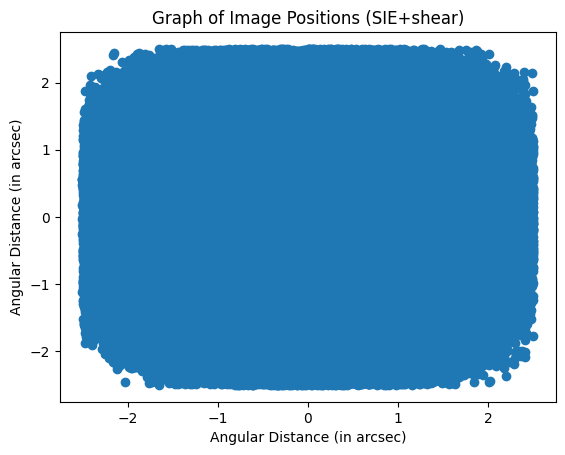

In [34]:
imX_both = [];
imY_both = [];

for i in typeLens_both["single"]:
    elem = vals_both[i]["img"]
    imX_both.append(elem[0][0])
    imY_both.append(elem[0][1])

for i in typeLens_both["double"]:
    elem = vals_both[i]["img"]
    imX_both.append(elem[0][0])
    imX_both.append(elem[1][0])
    imY_both.append(elem[0][1])
    imY_both.append(elem[1][1])
    
for i in typeLens_both["quad"]:
    elem = vals_both[i]["img"]
    imX_both.append(elem[0][0])
    imX_both.append(elem[1][0])
    imX_both.append(elem[2][0])
    imX_both.append(elem[3][0])
    
    imY_both.append(elem[0][1])
    imY_both.append(elem[1][1])
    imY_both.append(elem[2][1])
    imY_both.append(elem[3][1])

newX_both = np.array(imX_both)
newY_both = np.array(imY_both)

plt.scatter(newX_both, newY_both)

plt.xlabel('Angular Distance (in arcsec)')
plt.ylabel('Angular Distance (in arcsec)')
plt.title('Graph of Image Positions (SIE+shear)')


Text(0.5, 1.0, 'Graph of Source Positions (SIE+shear)')

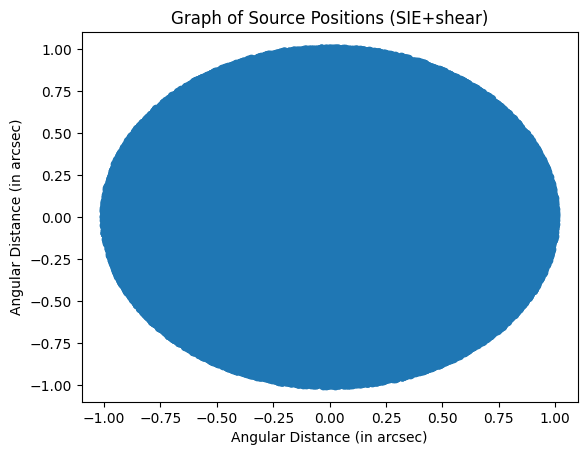

In [35]:
betaOne_both = [vals_both[i]["betaOne"] for i in range(len(vals_both))]
betaTwo_both = [vals_both[i]["betaTwo"] for i in range(len(vals_both))]
plt.scatter(betaOne_both,betaTwo_both)

plt.xlabel('Angular Distance (in arcsec)')
plt.ylabel('Angular Distance (in arcsec)')
plt.title('Graph of Source Positions (SIE+shear)')

#### Corner Plots for SIE+shear

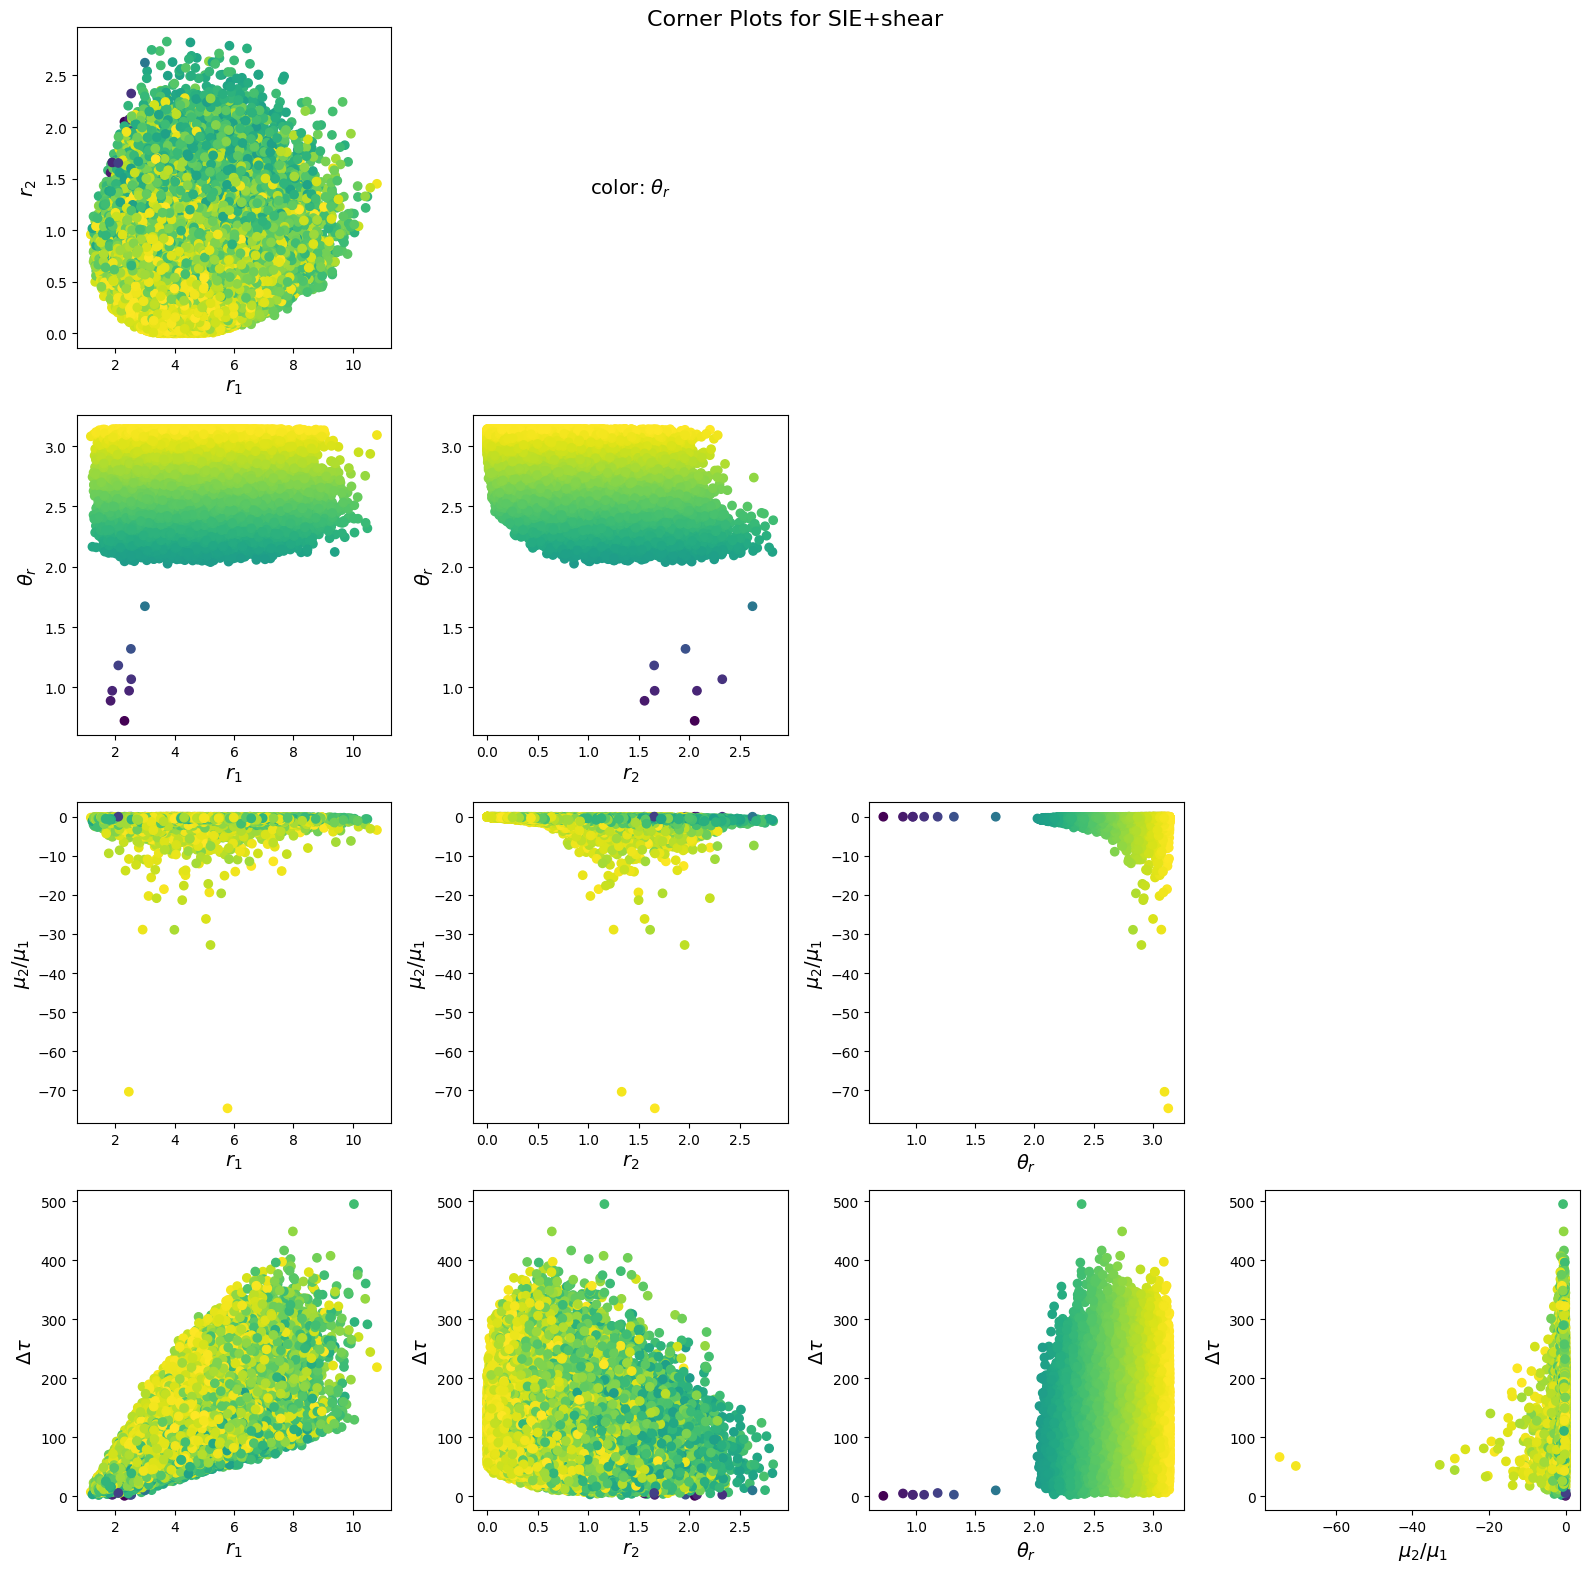

In [36]:
r_1 = [];
r_2 = [];

for i in typeLens_both["double"]:
    elem = vals_both[i]["img"]
    r_1.append(elem[0])
    r_2.append(elem[1])

theta_r = [];
for i in range(len(r_1)):
    theta_r.append(angle_between(r_1[i], r_2[i]))

R_1 = np.array([r_1[i][0]**2 + r_1[i][1]**2 for i in range(len(r_1))])
R_2 = np.array([r_2[i][0]**2 + r_2[i][1]**2 for i in range(len(r_2))])

mu_1 = np.array([vals_both[i]["mu"][0] for i in typeLens_both["double"]])
mu_2 = np.array([vals_both[i]["mu"][1] for i in typeLens_both["double"]])

ratio_mag = mu_2 / mu_1

timeDel_1 = np.array([vals_both[i]["time"][0].value for i in typeLens_both["double"]]) # this is always zero, so only second is interesting
timeDel_2 = np.array([vals_both[i]["time"][1].value for i in typeLens_both["double"]]) # second on is more interesting so would be focus.

tau = timeDel_2 - timeDel_1

### Time delay distance

z_l = np.array([vals_ellip[i]["zLens"] for i in typeLens_ellip["double"]])
z_s = np.array([vals_ellip[i]["zSrc"] for i in typeLens_ellip["double"]])

Dlens = [];
Dsrc = [];

for i in range(len(z_l)):
    Dlens.append(cosmo.comoving_distance(z_l[i]).value);
    Dsrc.append(cosmo.comoving_distance(z_s[i]).value);
    
D_l = np.array(Dlens)
D_s = np.array(Dsrc)

D_t = (D_l * D_s ) / (D_s - D_l) 

data = np.column_stack((R_1, R_2, theta_r, ratio_mag, tau)) # takes multiple arrays and stacks them on top of each other.
#r_1 refers to radius of image 1 and r_2 refers to radius of image 2.
visualize_data(data, 2, ['$r_1$', '$r_2$', r'$\theta_r$',r'$\mu_2 / \mu_1$',r'$\Delta\tau$'], 'Corner Plots for SIE+shear') 

In [37]:
data_path = Path("CombinedArrays")

In [39]:
vals_ellip = np.load(data_path / 'valEllip.npy', allow_pickle = True)
print(vals_ellip)

[{'img': array([[ 2.40024584,  0.86310406],
        [-0.68723423,  0.13312905]]), 'mu': array([ 2.5574824 , -0.52174675]), 'time': <Quantity [  0.        , 145.31271272] d>, 'deflec': array([[ 1.51332741,  0.83682218],
        [-1.57415267,  0.10684717]]), 'ellipc': np.float64(0.21164792897099602), 'ellips': np.float64(-0.3445748260171772), 'gammc': 0.0, 'gamms': 0.0, 'einrad': np.float64(1.3201363976025586), 'zLens': np.float64(0.32211822516587485), 'zSrc': np.float64(2.1674587226301867), 'betaOne': np.float64(0.8869184366913393), 'betaTwo': np.float64(0.026281881206333152)}
 {'img': array([[-2.09618946, -0.12359088],
        [ 0.74843415,  0.0876957 ]]), 'mu': array([ 2.91093205, -1.19975742]), 'time': <Quantity [  0.        , 162.28607233] d>, 'deflec': array([[-1.4258045 , -0.06595503],
        [ 1.41881911,  0.14533155]]), 'ellipc': np.float64(-0.05447935439134819), 'ellips': np.float64(0.03151433488007153), 'gammc': 0.0, 'gamms': 0.0, 'einrad': np.float64(1.3700738420076868), 'zL

In [40]:
vals_shear = np.load(data_path / 'valShear.npy', allow_pickle = True)
print(vals_shear)

[{'img': array([[ 2.15516031e+00,  4.55807325e-01],
        [-4.22563452e-01,  9.94886103e-04]]), 'mu': array([ 2.51159574, -0.45279725]), 'time': <Quantity [  0.        , 112.27662092] d>, 'deflec': array([[ 1.26824188,  0.42952544],
        [-1.30948189, -0.02528699]]), 'ellipc': 0.0, 'ellips': 0.0, 'gammc': np.float64(-0.025046969061884625), 'gamms': np.float64(0.06725626686290681), 'einrad': np.float64(1.3201363976025586), 'zLens': np.float64(0.32211822516587485), 'zSrc': np.float64(2.1674587226301867), 'betaOne': np.float64(0.8869184366913393), 'betaTwo': np.float64(0.026281881206333152)}
 {'img': array([[-1.99832161, -0.28052298],
        [ 0.68582194,  0.04764243]]), 'mu': array([ 3.20008355, -0.9785971 ]), 'time': <Quantity [  0.        , 153.82352319] d>, 'deflec': array([[-1.32793665, -0.22288714],
        [ 1.35620691,  0.10527828]]), 'ellipc': 0.0, 'ellips': 0.0, 'gammc': np.float64(-0.016383983641890976), 'gamms': np.float64(0.013925966533312684), 'einrad': np.float64(1.37

In [41]:

vals_both = np.load(data_path / 'valBoth.npy', allow_pickle = True)
print(vals_both)

[{'img': array([[ 2.33573925,  1.25496257],
        [-0.65096033,  0.14300903]]), 'mu': array([ 2.14528232, -0.44234312]), 'time': <Quantity [  0.        , 151.36517361] d>, 'deflec': array([[ 1.44882082,  1.22868069],
        [-1.53787877,  0.11672714]]), 'ellipc': np.float64(0.21164792897099602), 'ellips': np.float64(-0.3445748260171772), 'gammc': np.float64(-0.025046969061884625), 'gamms': np.float64(0.06725626686290681), 'einrad': np.float64(1.3201363976025586), 'zLens': np.float64(0.32211822516587485), 'zSrc': np.float64(2.1674587226301867), 'betaOne': np.float64(0.8869184366913393), 'betaTwo': np.float64(0.026281881206333152)}
 {'img': array([[-2.05988248, -0.22369224],
        [ 0.74023689,  0.07181207]]), 'mu': array([ 3.08372335, -1.13434829]), 'time': <Quantity [  0.        , 160.04951124] d>, 'deflec': array([[-1.38949752, -0.16605638],
        [ 1.41062185,  0.12944792]]), 'ellipc': np.float64(-0.05447935439134819), 'ellips': np.float64(0.03151433488007153), 'gammc': np.flo

In [42]:
print(len(vals_both))

100000


In [43]:
# checking for newly added params:

d1 = vals_both[0]["deflec"]
print(d1)

[[ 1.44882082  1.22868069]
 [-1.53787877  0.11672714]]
